In [1]:
import pandas as pd
import time
from urllib.request import urlopen
import requests
from bs4 import BeautifulSoup
from graphviz import Digraph
import re
import time
import scrapy

import warnings
warnings.filterwarnings("ignore")

# Web and Cloud Computing (DSCI 525): Lab 1
## General Lab Instructions

rubric={mechanics:4,quality:4,writing:2}

- Follow the [general lab instructions](https://ubc-mds.github.io/resources_pages/general_lab_instructions/).
- This assignment is to be completed in python, submitting both a `.ipynb` file (you can add your answers directly to this one) along with a rendered `.md`.
- I added an Intro section to help you with the basics for this lab. If you are already comfortable with scrapping data using python, you can safely skip it.

## Intro 

Let's have this intro section to introduce you to the main python functions to deal with web scrapping and crawling.

### Web requests

When you navigate to a website, there are many things going on under the hood. Many layers of protocols are used to allow you to communicate with a web server (take a look at the [OSI model](https://en.wikipedia.org/wiki/OSI_model) if you are curious). We will be mostly dealing with the last layer (Layer 7 - [application layer](https://en.wikipedia.org/wiki/Application_layer)) and [HTTP](https://en.wikipedia.org/wiki/Hypertext_Transfer_Protocol) (HyperText Transfer Protocol). We'll leave for the python libraries to handle the details of the other layers for us. 

HTTP is text based. For example, to send a GET request to a web server:
```
GET /HTTP/1.1
Host: www.google.com
User-Agent: Python-urllib/3.6
```
and the server send back a response, also with a header and the requested content.

Here we will use python (instead of a web browser like Chrome) to collect information from the web. For illustration purposes, let's scrap historical data of the Word Cups (soccer) available in [this wikipedia page](https://en.wikipedia.org/wiki/List_of_FIFA_World_Cup_winners).

#### The `urllib` package

The [`urllib`](https://docs.python.org/3/library/urllib.html) is a built-in package in python focused on dealing with URLs. To open and read URLs, we use the function [`urllib.request.urlopen`](https://docs.python.org/3/library/urllib.request.html#module-urllib.request). Let's start by importing this function.

In [2]:
from urllib.request import urlopen

Ok, now all we have to do is to call the function and pass the URL we want. Note that although we don't usually need to add the "http://" when we are using a web browser, here we do (try removing this part if you are curious).

In [3]:
soccer_urllib = urlopen("https://en.wikipedia.org/wiki/List_of_FIFA_World_Cup_winners")

Now our `soccer_urllib` contains some information of our request. For example:

In [4]:
print("The url of our request: ", end="")
print(soccer_urllib.geturl())

The url of our request: https://en.wikipedia.org/wiki/List_of_FIFA_World_Cup_winners


We can also get the header from the server's response (don't need to spend a lot of time trying to understand this header - it is just to show you how to access this info):

In [5]:
print(soccer_urllib.info())

Date: Sat, 23 Mar 2019 23:59:26 GMT
Content-Type: text/html; charset=UTF-8
Content-Length: 833473
Connection: close
Server: mw1329.eqiad.wmnet
X-Content-Type-Options: nosniff
P3P: CP="This is not a P3P policy! See https://en.wikipedia.org/wiki/Special:CentralAutoLogin/P3P for more info."
X-Powered-By: HHVM/3.18.6-dev
Content-language: en
Last-Modified: Wed, 13 Mar 2019 22:45:31 GMT
Backend-Timing: D=226277 t=1553197848441523
Vary: Accept-Encoding,Cookie,Authorization,X-Seven
X-Varnish: 196074366 510410410, 41161805 927736306, 299942035 1037394880, 772598691 738035058
Via: 1.1 varnish (Varnish/5.1), 1.1 varnish (Varnish/5.1), 1.1 varnish (Varnish/5.1), 1.1 varnish (Varnish/5.1)
Age: 101507
X-Cache: cp1087 hit/3, cp2010 hit/2, cp4032 hit/2, cp4030 hit/5
X-Cache-Status: hit-front
Server-Timing: cache;desc="hit-front"
Strict-Transport-Security: max-age=106384710; includeSubDomains; preload
Set-Cookie: WMF-Last-Access=23-Mar-2019;Path=/;HttpOnly;secure;Expires=Wed, 24 Apr 2019 12:00:00 GMT


Ok, but what about the content of the page? Let's check it out!

In [6]:
soccer_html = soccer_urllib.read()
#print(soccer_html)

Yes, it is a complete mess, I know. How to make sense of all this? Well, there are different approaches. We could use regular expression (not a good idea though), or we could use python packages such as [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) and [lxml](https://lxml.de/tutorial.html) to help you make sense of this thing. Here we will focus on `BeautifulSoup`, but you have seen `lxml` in 513, remember?

We have to be careful when using `urllib.request.open`, because if you request a webpage that does not exist, it will throw an exception and stop your program. Try running the commented code in the following cell:

In [7]:
#my_pg = urlopen("www.lourenzu.com")

The exceptions raised by `urllib.request` are defined in [`urllib.error`](https://docs.python.org/3/library/urllib.error.html#module-urllib.error). So we can import this package and make a more robust piece of code that handles these exceptions:

In [8]:
from urllib.error import HTTPError, URLError
try:
    my_pg = urlopen("http://www.lourenzu.com")
except URLError as error:
    print(error.reason)

[Errno 11001] getaddrinfo failed


In [9]:
try:
    my_pg = urlopen("http://www.google.com/rodolfo_lourenzutti")
except HTTPError as error:
    print("The famous error code: ", error.code)
    print("The reason for the exception:", error.reason)

The famous error code:  404
The reason for the exception: Not Found


Handling exceptions is an important part of web scrapping. Let's see an alternative package next.

#### The `requests` package

The [`requests`](http://docs.python-requests.org/en/master/user/quickstart/#custom-headers) package is an alternative (not built-in) HTTP library that is becoming more and more popular. Let's load the package and request our wikipedia page: 

In [10]:
import requests

soccer_requests = requests.get("https://en.wikipedia.org/wiki/List_of_FIFA_World_Cup_winners")

Differently from the `urllib`, requests does not raise an exception for HTTP errors:

In [11]:
bad_request = requests.get("http://www.google.com/rodolfo_lourenzutti")
bad_request

<Response [404]>

But it does raise an exception for some errors (uncomment the line below to see):

In [12]:
#requests.get("http://www.lourenzu.com")

Now, let's check the status code of our wikipedia request:

In [13]:
soccer_requests.status_code

200

In [14]:
soccer_requests.reason

'OK'

In [15]:
bad_request.status_code

404

In [16]:
bad_request.reason

'Not Found'

Great! Code 200 means everything is ok! We can also check the headers of the request and of the response: 

In [17]:
# Headers of the request
print(soccer_requests.request.headers)

{'User-Agent': 'python-requests/2.18.4', 'Accept-Encoding': 'gzip, deflate', 'Accept': '*/*', 'Connection': 'keep-alive'}


In [18]:
# Headers of the response
soccer_requests.headers

{'Date': 'Sat, 23 Mar 2019 23:59:27 GMT', 'Content-Type': 'text/html; charset=UTF-8', 'Content-Length': '70018', 'Connection': 'keep-alive', 'Server': 'mw1329.eqiad.wmnet', 'X-Content-Type-Options': 'nosniff', 'P3P': 'CP="This is not a P3P policy! See https://en.wikipedia.org/wiki/Special:CentralAutoLogin/P3P for more info."', 'X-Powered-By': 'HHVM/3.18.6-dev', 'Content-language': 'en', 'Last-Modified': 'Wed, 13 Mar 2019 22:45:31 GMT', 'Backend-Timing': 'D=226277 t=1553197848441523', 'Content-Encoding': 'gzip', 'Vary': 'Accept-Encoding,Cookie,Authorization,X-Seven', 'X-Varnish': '196074366 510410410, 41161805 927736306, 299942035 1037394880, 770953555 738035058', 'Via': '1.1 varnish (Varnish/5.1), 1.1 varnish (Varnish/5.1), 1.1 varnish (Varnish/5.1), 1.1 varnish (Varnish/5.1)', 'Age': '101508', 'X-Cache': 'cp1087 hit/3, cp2010 hit/2, cp4032 hit/2, cp4030 hit/6', 'X-Cache-Status': 'hit-front', 'Server-Timing': 'cache;desc="hit-front"', 'Strict-Transport-Security': 'max-age=106384710; in

Lastly, let's access the content of the page:

In [19]:
#soccer_requests.text

### Beautiful Soup

[`BeautifulSoup`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/) is a quite useful package to handle data in HTML format. It has two main functions 
1. [`BeautifulSoup.find()`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#find)
2. [`BeautifulSoup.find_all()`](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#find-all)

There are other functions that might be useful as well (e.g., `find_next_sibling()`, `find_parent()`) 

Let's starting by importing the library and creating a `BeautifulSoup` object.

In [20]:
from bs4 import BeautifulSoup

In [21]:
# Creating a BeautifulSoup object.
soccer = BeautifulSoup(soccer_requests.text) # remember that the field text contains the content of our request

Great! Now we have a `BeautifulSoup` object stored in the `soccer` variable. We can now use the function `find_all()` to retrieve information. For example, let's find the tables contained in the page.

In [22]:
tables = soccer.find_all("table")
#tables

Now we have a list of tables in the web page. Let's scrap the first table - the nations that won the word cup.

In [23]:
df = pd.DataFrame({"year": [], "Team": []})
row = []
df = []
for i,entry in enumerate(tables[0].find_all("td")):
    row.append(entry.text)
    if (i+1)%3 == 0:
        df.append(row)
        row = []

df = pd.DataFrame(df, columns = ["n_titles", "team", "years"])
df

,n_titles,team,years
0,5\n,Brazil\n,"1958, 1962, 1970, 1994, 2002\n"
1,4\n,Italy\n,"1934, 1938, 1982, 2006\n"
2,4\n,Germany[n 1]\n,"1954, 1974, 1990, 2014\n"
3,2\n,Uruguay\n,"1930, 1950\n"
4,2\n,Argentina\n,"1978, 1986\n"
5,2\n,France\n,"1998, 2018\n"
6,1\n,England\n,1966\n
7,1\n,Spain\n,2010\n


How cool is that? Of course we need some data cleaning.

In [24]:
df = df.replace("\n","", regex=True)
df = df.replace("\[[A-Za-z0-9 ]*\]","", regex=True)
df

,n_titles,team,years
0,5,Brazil,"1958, 1962, 1970, 1994, 2002"
1,4,Italy,"1934, 1938, 1982, 2006"
2,4,Germany,"1954, 1974, 1990, 2014"
3,2,Uruguay,"1930, 1950"
4,2,Argentina,"1978, 1986"
5,2,France,"1998, 2018"
6,1,England,1966
7,1,Spain,2010


As we can see, Brazil has the highest number of World Cup titles in the world. YEAH, yeah! Don't get upset, Canada would crush us in Hockey (I don't know if we even have a team!). We could keep manipulating this dataframe, but let's keep our focus on scrapping data. Let's get the names of the players that won the world cup, which are present in the third table of the wiki-page.

In [25]:
#tables[2]

In [26]:
players = []
teams = []
for entry in tables[2].find_all("td"):
    if entry.has_attr("data-sort-value"): # Note the function I'm using here: has_attr()
        players.append(entry.text)
        
players = pd.Series(players, name='Player').str.replace("\n","")
#players

But why are we doing this? Isn't easier to just copy the table directly from the page? Well, if you have only one table, it would be. But say that you want the date of birth of all these players that won the word cup. This information is not present in the table, so we need to gather from somewhere else. However, the table does provide us with the link for the wiki-page of each one of those players. We just need to go there and gather that information. Doing it manually for the 510 players would be annoying, right? 

Well, this could take a while since there are 510 players, but let's do for the first 25 players just so we get a taste.

In [27]:
url = "https://en.wikipedia.org"
bday = []
for name in players[0:25]:
    player_pg = requests.get(url+tables[2].find("a", text=name)["href"])
    player_pg = BeautifulSoup(player_pg.text)
    try:
        bday.append(player_pg.find("span", {"class":"bday"}).text)
    except:
        bday.append(player_pg.find("th", text="Date of birth").next_sibling.text)
    time.sleep(.5)

Why did I add a `time.sleep` in the code? It is to give some time to the server. We want to be polite and not overload the server with too many requests in a short time. You need to be aware of that. If you are dealing with a small server, you could cause real problems. Besides, you could get blocked. Wikipedia is a very big server, and we aren't requesting that many pages, so we should be fine here. But always keep this in mind. 

Now, let's check the date of birth of the first 25 players.

In [28]:
players_won_world_cup = pd.concat([players[0:25],pd.Series(bday, name="bday")], axis=1)
players_won_world_cup

,Player,bday
0,Pelé,1940-10-23
1,Hilderaldo Bellini,1930-06-07
2,Cafu,1970-06-07
3,Castilho,1932-11-27
4,Didi,1928-10-08
5,Djalma Santos,1929-02-27
6,Giovanni Ferrari,1907-12-06
7,Garrincha,1933-10-28
8,Gilmar,1930-08-22
9,Guido Masetti,1907-11-22


Cool, right? 
One last thing before you start: your browser's developer tools is your ally in navigating a website structure. 

Finally, let's begin your assigment.

# Exercise 1: Creating a prerequisite diagram
rubric={accuracy:35,viz:15}

Below is a prerequisite chart for the 25 MDS courses:

![](MDS-prereq2.png)

In this assignment, you will reproduce this graph, or something very similar, by scraping the prerequisite info from https://courses.students.ubc.ca/cs/main?pname=subjarea&tname=subjareas&req=1&dept=DSCI.

In this assignment, you will implement a simple crawler to crawl and scrape UBC SSC web pages to grab your course schedule. Here are the steps of what you have to do:

1. Request the url https://courses.students.ubc.ca/cs/main?pname=subjarea&tname=subjareas&req=1&dept=DSCI;
2. Create a `BeautifulSoup` object from the retrieved webpage;
3. Now, for each one of the courses in the page:
    1. obtain the respective link;
    2. retrieve the pre-reqs;

In [29]:
# TODO

# Task  A

In [30]:
mds_request=requests.get('https://courses.students.ubc.ca/cs/courseschedule?pname=subjarea&tname=subj-department&dept=DSCI')
mds=BeautifulSoup(mds_request.text)

In [31]:
prereqs=pd.DataFrame({'CourseName':[],'Url':[]})
url_start='https://courses.students.ubc.ca'
url_long=[]
course_num=[]
course_name=[]
for nam in mds.find_all('td'):
    url=[]
    level= nam.find_all('a')
    if not level:
        course_name.append(nam.text);
    else :
        url.append(url_start+level[0]['href'])
        course_num.append(level[0].text)
        url_long.append(url[0])    

final_df=pd.DataFrame({'Course Number': course_num,'Course Name':course_name[0:len(url_long)],'URL':url_long})


In [32]:
mds.find_all('td')

[<td><a href="/cs/courseschedule?pname=subjarea&amp;tname=subj-course&amp;dept=DSCI&amp;course=100">DSCI 100</a></td>,
 <td>Introduction to Data Science</td>,
 <td><a href="/cs/courseschedule?pname=subjarea&amp;tname=subj-course&amp;dept=DSCI&amp;course=511">DSCI 511</a></td>,
 <td>Programming for Data Science</td>,
 <td><a href="/cs/courseschedule?pname=subjarea&amp;tname=subj-course&amp;dept=DSCI&amp;course=512">DSCI 512</a></td>,
 <td>Algorithms and Data Structures</td>,
 <td><a href="/cs/courseschedule?pname=subjarea&amp;tname=subj-course&amp;dept=DSCI&amp;course=513">DSCI 513</a></td>,
 <td>Databases and Data Retrieval</td>,
 <td><a href="/cs/courseschedule?pname=subjarea&amp;tname=subj-course&amp;dept=DSCI&amp;course=521">DSCI 521</a></td>,
 <td>Computing Platforms for Data Science</td>,
 <td><a href="/cs/courseschedule?pname=subjarea&amp;tname=subj-course&amp;dept=DSCI&amp;course=522">DSCI 522</a></td>,
 <td>Data Science Workflows</td>,
 <td><a href="/cs/courseschedule?pname=sub

In [33]:
req=[]
for ii in range(len(final_df['URL'])):
    prep=BeautifulSoup(requests.get(final_df.loc[ii,'URL']).text)

    alt = prep.find("div", {"class":"content expand"})
    m=alt.find_all('p')
    prereq=[]
    for i in m:
        for k in i.find_all('a'):
            prereq.append(k.text)
    req.append(prereq)
final_df['Pre_Req']=req   

In [34]:
final_df

,Course Number,Course Name,URL,Pre_Req
0,DSCI 100,Introduction to Data Science,https://courses.students.ubc.ca/cs/coursesched...,[]
1,DSCI 511,Programming for Data Science,https://courses.students.ubc.ca/cs/coursesched...,[]
2,DSCI 512,Algorithms and Data Structures,https://courses.students.ubc.ca/cs/coursesched...,"[DSCI 511, DSCI 521]"
3,DSCI 513,Databases and Data Retrieval,https://courses.students.ubc.ca/cs/coursesched...,[]
4,DSCI 521,Computing Platforms for Data Science,https://courses.students.ubc.ca/cs/coursesched...,[]
5,DSCI 522,Data Science Workflows,https://courses.students.ubc.ca/cs/coursesched...,"[DSCI 511, DSCI 521]"
6,DSCI 523,Data Wrangling,https://courses.students.ubc.ca/cs/coursesched...,"[DSCI 511, DSCI 521]"
7,DSCI 524,Collaborative Software Development,https://courses.students.ubc.ca/cs/coursesched...,[DSCI 522]
8,DSCI 525,Web and Cloud Computing,https://courses.students.ubc.ca/cs/coursesched...,"[DSCI 522, DSCI 523]"
9,DSCI 531,Data Visualization I,https://courses.students.ubc.ca/cs/coursesched...,"[DSCI 511, DSCI 521]"


> The URL's are not displaying completely but the links work because of which I go to that link and then from that new html i extract the Pre requisitives.

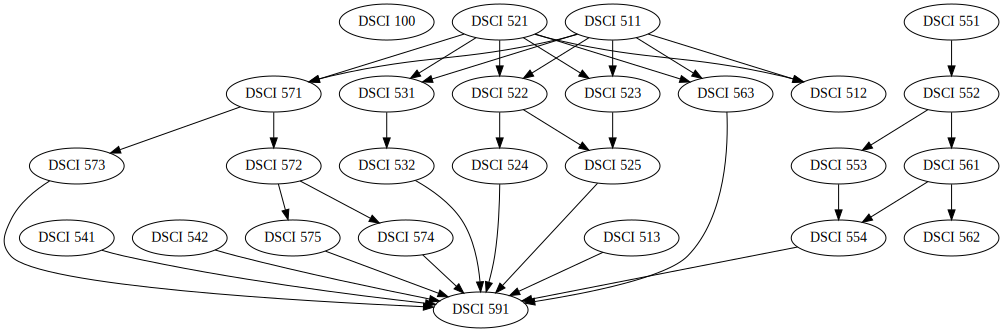

In [35]:
from graphviz import Graph
from graphviz import render
dot = Digraph(comment='MDS')

for i in final_df['Course Number']:
    dot.node(i)

for k in range(len(final_df['Pre_Req'])):
    for m in range(len(final_df.iloc[k,3])):
        dot.edge(final_df.iloc[k,3][m],final_df.iloc[k,0])
dot

# (Optional) Exercise 2 
rubric={accuracy:1}

In this exercise you will use the [`Scrapy`](https://docs.scrapy.org/en/latest/intro/tutorial.html) package to do the scrapping you did in Exercise 1. This cannot be done in Jupyter notebook, so check the file `lab1_question2.md` in lab1 folder for instructions.

# (Optional) Exercise 3
rubric={accuracy:1}

Taking this to the next level, you could point your scraping up one level to this page: https://courses.students.ubc.ca/cs/main?pname=subjarea&tname=subjareas&req=0
Crawl through _all_ subjects and _all_ courses and report the course with the largest number of students enrolled.

# Exercise 4
rubric={accuracy:50}

All the Game of Thrones episodes are listed, by season, in the following URL: https://en.wikipedia.org/wiki/List_of_Game_of_Thrones_episodes

Unfortunately, the running time of each episode is not available. However, in the link provided for each episodes (e.g., https://en.wikipedia.org/wiki/Dragonstone_(Game_of_Thrones)) there is the running time of the respective episode. Collect the episodes' titles, season, number of U.S. viewers, and running time from wikipedia and create a pandas dataframe with the information collected.

In [36]:
got_request=requests.get('https://en.wikipedia.org/wiki/List_of_Game_of_Thrones_episodes')
got=BeautifulSoup(got_request.text)

In [37]:
got_tables = got.find_all("table")

In [38]:
seasons=[]
titles=[]
viewers=[]
url=[]
url_start='https://en.wikipedia.org'

for i in range(7):
    table_num=i+2
    
    table=got_tables[table_num].find_all('tr',{'class':'vevent'})
    
    for m in range(len(table)):
        seasons.append(i+1)
        titles.append(table[m].find_all('td')[1].text)
        viewers.append(table[m].find_all('td')[5].text.split('[')[0])
        url.append(url_start+table[m].find_all('a', {'href':True})[0]['href'])

GameOfThrones=pd.DataFrame({'Seasons':seasons,'Title':titles,'Viewers (Millions)':viewers, 'url':url})

In [39]:
GameOfThrones.head()

,Seasons,Title,Viewers (Millions),url
0,1,"""Winter Is Coming""",2.22,https://en.wikipedia.org/wiki/Winter_Is_Coming
1,1,"""The Kingsroad""",2.20,https://en.wikipedia.org/wiki/The_Kingsroad
2,1,"""Lord Snow""",2.44,https://en.wikipedia.org/wiki/Lord_Snow
3,1,"""Cripples, Bastards, and Broken Things""",2.45,"https://en.wikipedia.org/wiki/Cripples,_Bastar..."
4,1,"""The Wolf and the Lion""",2.58,https://en.wikipedia.org/wiki/The_Wolf_and_the...


In [40]:
duration_list=[]
for url_link in GameOfThrones.url:
    duration=requests.get(url_link)
    duration_got=BeautifulSoup(duration.text)
    duration_list.append(duration_got.find_all('table',{'class':'infobox vevent'})[0].find_all('td')[9].text.split('[')[0])

In [41]:
GameOfThrones['Duration']=duration_list

In [42]:
duration=requests.get(GameOfThrones.url[5])
duration_got=BeautifulSoup(duration.text)
GameOfThrones.Duration[5]=duration_got.find_all('table',{'class':'infobox vevent'})[0].find_all('td')[10].text.split('[')[0]

In [43]:
GameOfThrones.head()

,Seasons,Title,Viewers (Millions),url,Duration
0,1,"""Winter Is Coming""",2.22,https://en.wikipedia.org/wiki/Winter_Is_Coming,62 minutes
1,1,"""The Kingsroad""",2.20,https://en.wikipedia.org/wiki/The_Kingsroad,56 minutes
2,1,"""Lord Snow""",2.44,https://en.wikipedia.org/wiki/Lord_Snow,58 minutes
3,1,"""Cripples, Bastards, and Broken Things""",2.45,"https://en.wikipedia.org/wiki/Cripples,_Bastar...",56 minutes
4,1,"""The Wolf and the Lion""",2.58,https://en.wikipedia.org/wiki/The_Wolf_and_the...,55 minutes
